In [1]:
import os
import pickle

# import the package needed to solve the environnement
from scipy.optimize import linear_sum_assignment #hungarian matching algorithm
import numpy as np
from scipy.stats import beta, bernoulli,norm
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF

# 2 Decisions env

In [5]:
class Two_decision_env():
    """
    Create an environment with 2 decisions composed of d items with reward a and b with a>b>1/2
    
    """ 
    def __init__(self,m,a = 1,b = 0.9,sigma = 1,random_variable = "bernoulli"):
        self.m = m
        self.a = a
        self.b = b
        self.sigma = sigma
        
        self.random_variable = random_variable
                 
    def draw(self, decision):
        """
        Draw a vector of reward
        
        """
        if self.random_variable == "bernoulli":
            if decision == 0:
                reward = bernoulli.rvs(self.a, size = self.m)
            elif decision == 1:
                reward = bernoulli.rvs(self.b, size = self.m)
                
        elif self.random_variable == "gaussian":
            if decision == 0:
                reward = norm.rvs(self.a, scale=self.sigma, size = self.m)
            elif decision == 1:
                reward = norm.rvs(self.b, scale=self.sigma, size = self.m)
            
        if decision == 1:
            regret = (self.a-self.b)*self.m
        elif decision == 0:
            regret = 0
            
        return reward, regret

# ESCB

In [ ]:
class ESCB():
    """
    TS for the two decision environnement
    """
    def __init__(self, m,n_init = 0):
        
        self.iteration = 0
        self.m = m
    
        self.numplayed = np.zeros(2)
        
        self.mu = np.zeros(2*self.m)
        self.sigma = np.zeros(2*self.m)
        
        self.initialization = False
        
        self.n_init = n_init # sample n_init time each decision
        if self.n_init > 0:   
            self.initialization = True
        
        self.playhist = []
        
         
    def reset(self):
        self.iteration = 0
        self.weight_draw = np.zeros(2*m)
        self.numplayed = np.zeros(2)
        self.playhist = []
        
        if self.n_init > 0:   
            self.initialization = True
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        
        if self.iteration < self.n_init:
            self.decision = 0
            self.playhist.append(self.decision)
            return(self.decision)
        
        if self.iteration < 2*self.n_init:
            self.decision = 1
            self.playhist.append(self.decision)
            return(self.decision)
        else:       
            self.initialization = False
        
            
                    
        index_a = np.sum(self.mu[:self.m])+np.sqrt(m/2*self.f()/self.numplayed[0])
        index_b = np.sum(self.mu[self.m:])+np.sqrt(m/2*self.f()/self.numplayed[0])
        if index_a > index_b:
            self.decision = 0
        else :
            self.decision = 1
            
            
        self.playhist.append(self.decision)

        return self.decision
    
    def f(self):
        return np.log(self.iteration)+4*self.m*np.log(np.log(self.iteration))

    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration += 1
        self.numplayed[self.decision] += 1
        
        if self.decision == 0:    
            self.mu[:self.m] = (self.mu[:self.m]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
        elif self.decision == 1:
            self.mu[self.m:] = (self.mu[self.m:]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]


# TS

In [6]:
class CTS_exp():
    """
    TS for the two decision environnement
    """
    def __init__(self, m,n_init = 0, post_distrib = "beta"):
        
        self.iteration = 0
        self.m = m
        
        
        self.weight_draw = np.zeros(2*m)
        self.numplayed = np.zeros(2)
        
        self.initialization = False
        
        self.n_init = n_init # sample n_init time each decision
        if self.n_init > 0:   
            self.initialization = True
        
        
        self.post_distrib = post_distrib
        self.playhist = []
        self.decision = 1
        
        
        if self.post_distrib == "beta":
            self.alpha = np.ones(2*self.m)
            self.beta = np.ones(2*self.m)
        elif self.post_distrib == "gaussian":
            self.mu = np.zeros(2*self.m)
            self.sigma = np.zeros(2*self.m)
        
        

         
    def reset(self):
        self.iteration = 0
        self.weight_draw = np.zeros(2*m)
        self.numplayed = np.zeros(2)
        self.playhist = []
        self.decision = 1
        
        if self.n_init > 0:   
            self.initialization = True
    
        if self.random_variable == "beta":
            self.alpha = np.ones(2*self.m)
            self.beta = np.ones(2*self.m)
        elif self.random_variable == "gaussian":
            self.mu = np.zeros(2*self.m)
            self.sigma = np.zeros(2*self.m)
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        
        if self.iteration < self.n_init:
            self.decision = 0
            self.playhist.append(self.decision)
            return(self.decision)
        
        if self.iteration < 2*self.n_init:
            self.decision = 1
            self.playhist.append(self.decision)
            return(self.decision)
        else:       
            self.initialization = False
        
            
        if self.post_distrib == "beta":
            self.weight_draw = beta.rvs(self.alpha, self.beta)
            
        elif self.post_distrib == "gaussian": 
            self.weight_draw = norm.rvs(self.mu, self.sigma)
                    
        mean_a = np.sum(self.weight_draw[:self.m])
        mean_b = np.sum(self.weight_draw[self.m:])
        if mean_a > mean_b:
            self.decision = 0
        else :
            self.decision = 1
            
            
        self.playhist.append(self.decision)

        return self.decision


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration += 1
        self.numplayed[self.decision] += 1
        
        if self.post_distrib == "beta":
            if self.decision == 0:    
                self.alpha[:self.m] += observation
                self.beta[:self.m] += 1-observation
            elif self.decision == 1:
                self.alpha[self.m:] += observation
                self.beta[self.m:] += 1-observation
        if self.post_distrib == "gaussian":
            if self.decision == 0:    
                self.mu[:self.m] = (self.mu[:self.m]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
                self.sigma[:self.m] =  1/np.sqrt(self.numplayed[self.decision])
            elif self.decision == 1:
                self.mu[self.m:] = (self.mu[self.m:]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
                self.sigma[self.m:] =  1/np.sqrt(self.numplayed[self.decision])

# TS First Optimal play 

## Cold Start

m =  7
begin_trial 0
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still n

Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not pla

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not playe

Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still n

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still n

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not pla

Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still n

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played 

Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not p

Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not p

Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not p

Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still n

Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not p

Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have sti

Have still not played the optimal arm at time 12000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000


Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still n

Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still n

Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still n

Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not playe

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still n

Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still n

Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played

Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still n

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not p

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not p

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not p

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not p

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
begin_trial 500
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not pl

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
H

Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still n

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have sti

Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 222000
Have still not played the optimal arm at time 224000
Have still not played the optimal arm at time 226000
Have still not played the optimal arm at time 228000
Have still not played the optimal arm at time 230000
Have still not played the optimal arm at time 232000
Have still not played the optimal arm at time 234000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still n

Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not 

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still n

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not p

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still n

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still n

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not p

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still n

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still n

Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not p

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not play

Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not p

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not 

Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have s

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still n

Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not p

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not pla

Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the 

Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the 

Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not play

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
begin_trial 200
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have 

Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have s

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not p

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the o

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played

Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played th

Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still n

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not p

Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played 

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the opti

Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
begin_trial 700
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still

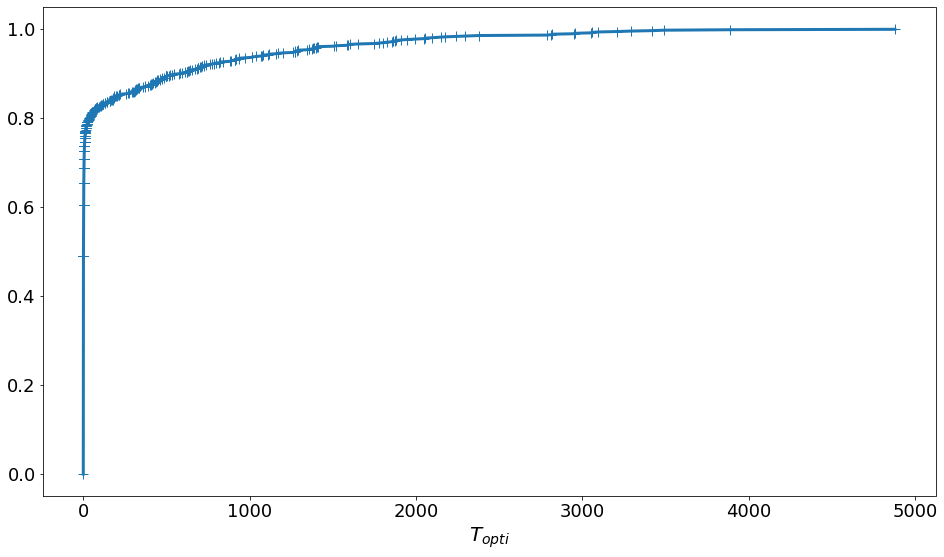

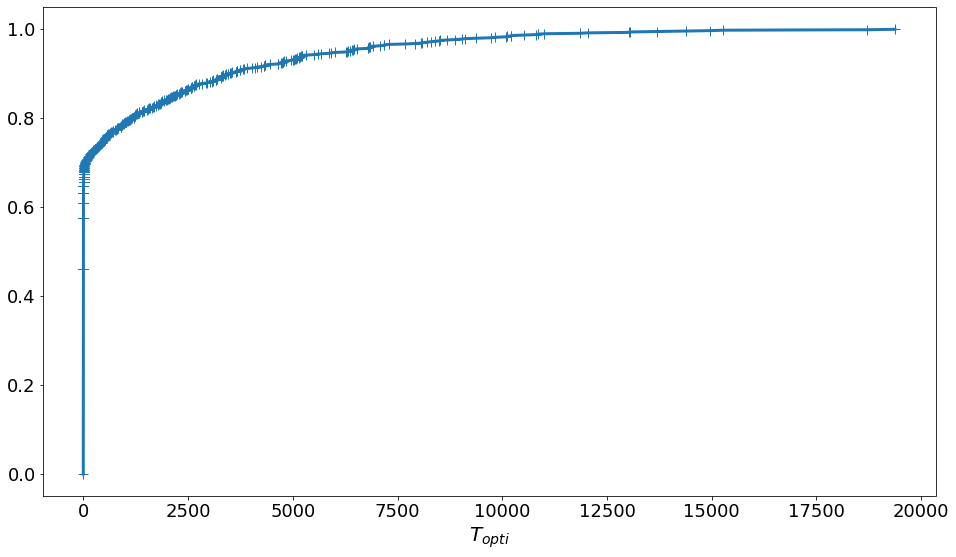

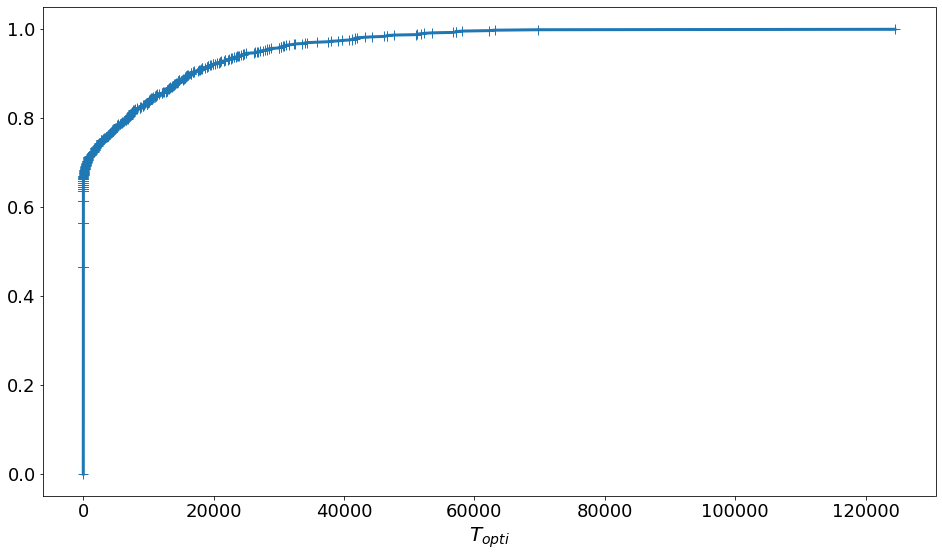

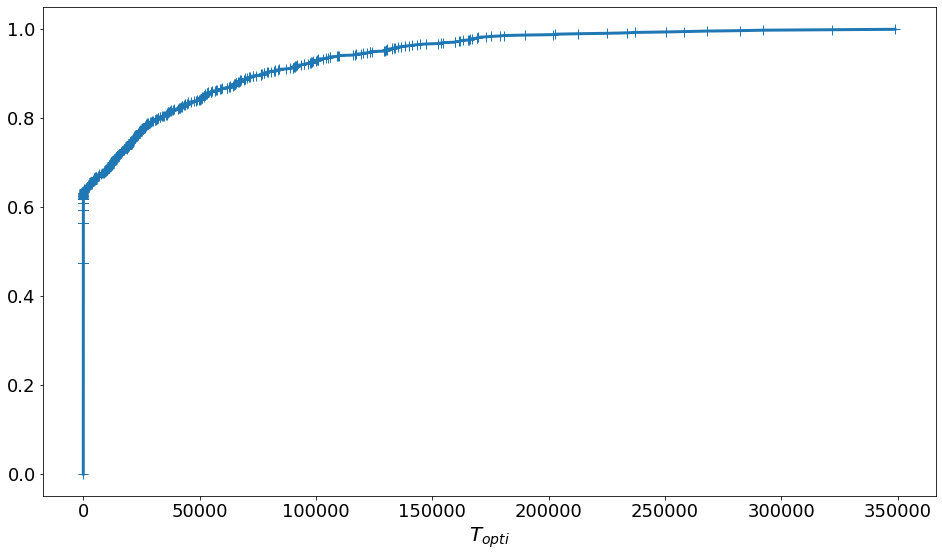

In [13]:
# testing the first time optimal is played

# Params
jump = 1
ms = list(range(4,8,jump))
n_trial = 1000 
a=1
b=0.9
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["a"] = a
Param_dict["b"] = b
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib

upper_limit = 20000000

# Save Folder
experimentfolder = "Experience_opti_{}_{}_{}_a{:.3f}b{:.3f}".format(ms[0],ms[-1],jump,a,b)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()

distrib_first_optimal = [[] for m in ms]


for i,m in enumerate(ms[::-1]):
    print("m = ",m) 
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b)
        player = CTS_exp(m,n_init = n_init)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while player.decision and counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))

        distrib_first_optimal[-(i+1)].append(counter)   

np.save(experimentfolder +"\\Distribution",distrib_first_optimal)

#plot Result ECDF

for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    cdf = ECDF(distrib_first_optimal[i])
    plt.plot([0]+list(np.sort(distrib_first_optimal[i])),[0]+list(cdf(np.sort(distrib_first_optimal[i]))),"+-",linewidth=3,markersize=10)
#plt.title("Distribution of first optimal play  for b = {:.1f} and d = {:d} ".format(b,d),fontsize=20)   
    plt.xlabel(r'$T_{opti}$', fontsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
    plt.savefig(experimentfolder+'\\ECDF_m{}_l{}.pdf'.format(m,n_init))


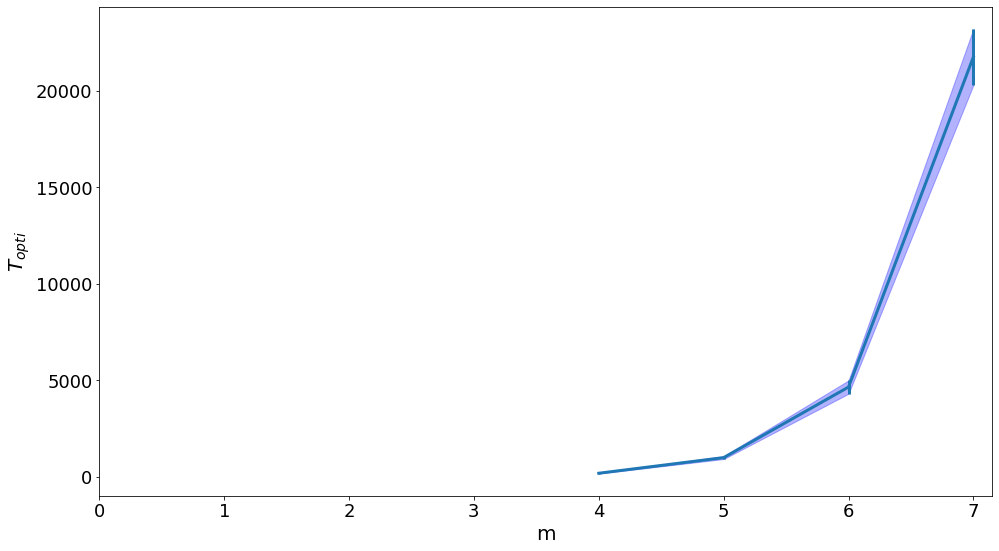

In [17]:
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)

plt.figure('Average Time',figsize = (16,9))
plt.clf()
plt.errorbar(ms, Average_time, std, linewidth=3)
plt.fill_between(ms,Average_time - std, Average_time + std , color='b', alpha=.3)


plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
plt.ylabel(r'$T_{opti}$', fontsize=20)
plt.xlabel('m', fontsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.savefig(experimentfolder +"\\Averagel{}.pdf".format(n_init))

## Warm Start

## Exploit those results

# Regret

Simulate some regret trajectories either with Thompson,Thompson warm start or ESCB

In [ ]:
# Param


# Params
jump = 2
ms = list(range(10,21,jump))

n_trial = 50
upper_limit = 100000
a=1
b=0.998
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["a"] = a
Param_dict["b"] = b
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib
Param_dict["n_init"] = n_init
Param_dict["upper_limit"] = upper_limit



# Save Folder
experimentfolder = "Experience_regret_{}_{}_{}_a{:.3f}b{:.3f}".format(ms[0],ms[-1],jump,a,b)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()


## TS Coldstart

In [ ]:

regrets = np.zeros((len(ds),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = CTS_exp(m,n_init = 0, post_distrib = post_distrib)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                

                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*m*(a-b)

        
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\TS_regret_m{}_l{}.pdf'.format(m,0))
    

## TS Warm Start

In [ ]:
regrets = np.zeros((len(ds),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    n_init = 2*m
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = CTS_exp(m,n_init = 0, post_distrib = post_distrib)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                

                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*m*(a-b)

        
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\TS_regret_m{}_l{}.pdf'.format(m,2*m))
    

## ESCB

In [ ]:

regrets = np.zeros((len(ds),n_trial,upper_limit))



for i,m in enumerate(ms):
    print("d = ",m)
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(m,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = ESCB(m,n_init = 1)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                
                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*m*(a-b)

for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\ESCB_regret_m{}.pdf'.format(m))